In [2]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd

In [7]:
nc_file = './arctic-ssh-y2002.nc'
ds = nc.Dataset(nc_file)
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(y, x)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    _CoordinateAxisType: Lon
unlimited dimensions: 
current shape = (452, 406)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 latitude(y, x)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    _CoordinateAxisType: Lat
unlimited dimensions: 
current shape = (452, 406)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: forecast time
    units: hours since 1950-1-1 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (365,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 ssh(time, y, x)
    standard_name: sea_surface_elevation
    units: m
    coordinates: latitude longitude
 

## Функция для поиска индекса ближайшей ячейки по координатам (тест)

In [15]:
def idx_by_2coord(coordinate, lat_array, lon_array):
    # делаем один двумерный массив, в котором каждая ячейка содержит и широту и долготу
    coord_array=np.concatenate((np.array([np.ravel(lat_array)]).T, np.array([np.ravel(lon_array)]).T), axis=1)
    # переворачиваем его к исходной форме
    coord_array=np.reshape(coord_array, (lat_array.shape[0],lat_array.shape[1], 2))
    # вычитаем из каждой координаты нашу координату
    dif=np.abs(coord_array-coordinate)
    # суммируем модули отклонения по обеим координатам
    dis=np.sum(dif, axis=2)
    
    #plt.imshow(dis) # центр "крестика" и есть наша точка
    
    # извлекаем индекс центра "крестика"
    geo_idx = np.unravel_index(dis.argmin(), dis.shape)
    return geo_idx

In [16]:
np.array(ds['latitude'])

array([[54.87813 , 54.966038, 55.053806, ..., 57.00305 , 56.919785,
        56.836338],
       [54.953148, 55.0413  , 55.129314, ..., 57.083508, 56.99998 ,
        56.916275],
       [55.02797 , 55.116367, 55.204624, ..., 57.16378 , 57.07999 ,
        56.99603 ],
       ...,
       [47.76056 , 47.832794, 47.904858, ..., 49.557858, 49.490986,
        49.42392 ],
       [47.670074, 47.742107, 47.813965, ..., 49.463078, 49.396416,
        49.32955 ],
       [47.579506, 47.651333, 47.72299 , ..., 49.368225, 49.30177 ,
        49.23511 ]], dtype=float32)

## Запускаем в цикле, формируем временной ряд

In [26]:
coordinates_from_map={'lat':[75.532663, 76.006222, 75.210923],
                      'lon':[17.902096, 24.893752, 11.252254]}

names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
#print(names_dict)

for j in range(365):  
    for i in range (len(coordinates_from_map['lat'])):        
        
        sea_level=np.array(ds['ssh'])[j]

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = ds.variables['latitude'][:]
        lons = ds.variables['longitude'][:]

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)
names_dict

{'75.532663_17.902096': [-0.4675337,
  -0.43214214,
  -0.45911416,
  -0.43376508,
  -0.46568653,
  -0.40571618,
  -0.41062978,
  -0.45822427,
  -0.45332485,
  -0.44367027,
  -0.4658115,
  -0.4528848,
  -0.46554342,
  -0.47601444,
  -0.42434502,
  -0.40794143,
  -0.43316433,
  -0.39988488,
  -0.40286186,
  -0.42016116,
  -0.44789234,
  -0.5023701,
  -0.4856149,
  -0.48664805,
  -0.4417759,
  -0.40933856,
  -0.37690124,
  -0.40849262,
  -0.43918532,
  -0.43324915,
  -0.42186695,
  -0.40200546,
  -0.39202118,
  -0.3927012,
  -0.44132924,
  -0.4390998,
  -0.41149834,
  -0.42161942,
  -0.42977896,
  -0.4333697,
  -0.45801827,
  -0.51051885,
  -0.47940972,
  -0.46165615,
  -0.45727557,
  -0.4509419,
  -0.48414177,
  -0.46014622,
  -0.4600913,
  -0.47102815,
  -0.48933813,
  -0.53099495,
  -0.5591734,
  -0.551678,
  -0.6109211,
  -0.5451613,
  -0.5334861,
  -0.52528846,
  -0.5098275,
  -0.5128612,
  -0.4996575,
  -0.49651155,
  -0.5034338,
  -0.4816158,
  -0.46668467,
  -0.46093842,
  -0.4745

### Сортировка и запись набора данных в csv

In [24]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
per = pd.date_range(start ='1-1-2002', end ='31-12-2002', freq ='1D')
pd_df['dates']=per
pd_df=pd_df.sort_values(by=['dates'])
pd_df.to_csv('./timelines_data/formed_timelines_2002/2002_ARCTIC_reanalysis.csv', sep=';', index=False)
pd_df

,75.532663_17.902096,76.006222_24.893752,75.210923_11.252254,dates
0,-0.467534,-0.481149,-0.501914,2002-01-01
1,-0.432142,-0.434702,-0.472039,2002-01-02
2,-0.459114,-0.463210,-0.460948,2002-01-03
3,-0.433765,-0.454657,-0.445413,2002-01-04
4,-0.465687,-0.433384,-0.460599,2002-01-05
...,...,...,...,...
360,-0.347166,-0.367057,-0.455382,2002-12-27
361,-0.369520,-0.383776,-0.458292,2002-12-28
362,-0.387371,-0.387457,-0.450590,2002-12-29
363,-0.374828,-0.378650,-0.437877,2002-12-30


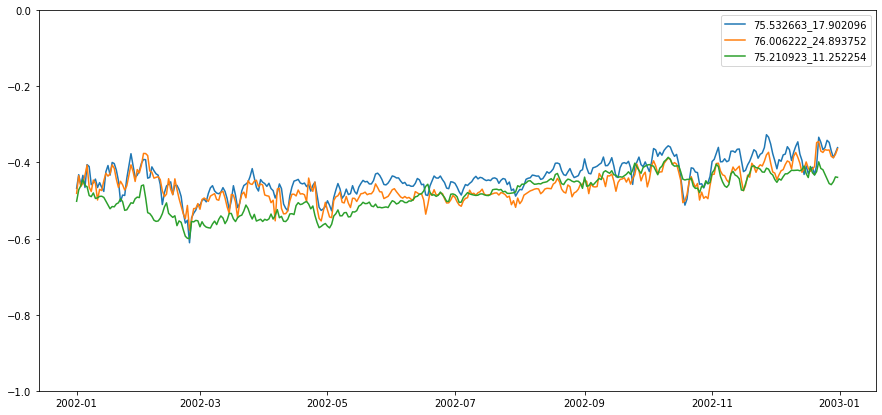

In [25]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)
plt.ylim(-1, 0)
plt.legend()
plt.show()